In [22]:
!pip install -r requirement.txt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.4/996.4 kB 4.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 5.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 5.9 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [shap]4/5 [shap]]te]


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import shap
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

In [8]:
# MySQL connection details
username = "root"
password = urllib.parse.quote_plus("Midhun@123")  # URL-encode special characters
host = "localhost"
port = "3306"
database = "fashion_europe_2025"

# Create the connection engine
engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

In [9]:
dim_products_df = pd.read_sql("SELECT * FROM dim_products", con=engine)
print(dim_products_df.head())

   product_id        product_name  category brand  color size  catalog_price  \
0           1     Soft Wrap Dress   Dresses  Tiva  Green    S          40.41   
1           2       Soft Wrap Tee  T-Shirts  Tiva  White    S          78.45   
2           3      Soft Linen Tee  T-Shirts  Tiva  Green   XL          23.90   
3           4     Soft Ribbed Tee  T-Shirts  Tiva  White    S          60.00   
4           5  Soft Wrap Trousers     Pants  Tiva   Blue    M          36.84   

   cost_price  gender  
0       20.70  Female  
1       53.76  Female  
2       14.81  Female  
3       34.78  Female  
4       16.46  Female  


In [10]:
dim_products_df = pd.read_sql("SELECT * FROM dim_products", con=engine)
fact_sales_df = pd.read_sql("SELECT * FROM fact_sales", con=engine)
dim_channels_df = pd.read_sql("SELECT * FROM dim_channels", con=engine)
dim_campaigns_df = pd.read_sql("SELECT * FROM dim_campaigns", con=engine)

merged_df = fact_sales_df.merge(dim_products_df, on="product_id", how="left") \
                         .merge(dim_channels_df, on="channel_id", how="left") \
                         .merge(dim_campaigns_df, on="campaign_id", how="left")


In [11]:
df = merged_df

In [12]:
# 1) Create profit margin and high_margin target
df['profit_margin'] = df['unit_price'] - df['cost_price']
median_margin = df['profit_margin'].median()
df['high_margin'] = (df['profit_margin'] >= median_margin).astype(int)
print(f"Median profit margin: {median_margin:.2f}")
print("Target distribution (high_margin):")
print(df['high_margin'].value_counts(normalize=True))

Median profit margin: 20.43
Target distribution (high_margin):
high_margin
1    0.501217
0    0.498783
Name: proportion, dtype: float64


In [13]:
# --- Classification: Predict high_margin ---
# Features to use (drop brand/gender if constant)
cat_features = ['category', 'color', 'size', 'channel_name', 'campaign_name']
num_features = ['unit_price', 'quantity', 'catalog_price', 'original_price']

# remove any constant columns automatically
cat_features = [c for c in cat_features if c in df.columns and df[c].nunique() > 1]
num_features = [c for c in num_features if c in df.columns]


In [15]:
X = df[cat_features + num_features].copy()
y = df['high_margin']

# Missing value handling & encoding pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features),
    ('num', num_pipeline, num_features)
])

# Full pipeline with classifier
clf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Fit
clf_pipeline.fit(X_train, y_train)


,steps,"[('preproc', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
# Predict & evaluate
y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       246
           1       0.98      0.98      0.98       248

    accuracy                           0.98       494
   macro avg       0.98      0.98      0.98       494
weighted avg       0.98      0.98      0.98       494

ROC AUC: 0.9979920666142145


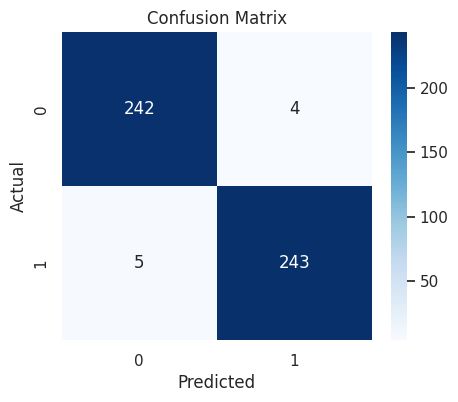

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
# FGet feature names after preprocessing
# Workaround to extract feature names for RandomForest
ohe_cols = []
if 'cat' in preprocessor.transformers_[0][0]:
    # extract categories from fitted OneHotEncoder
    ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_names = ohe.get_feature_names_out(cat_features).tolist()
else:
    cat_names = []
num_names = num_features
feature_names = cat_names + num_names


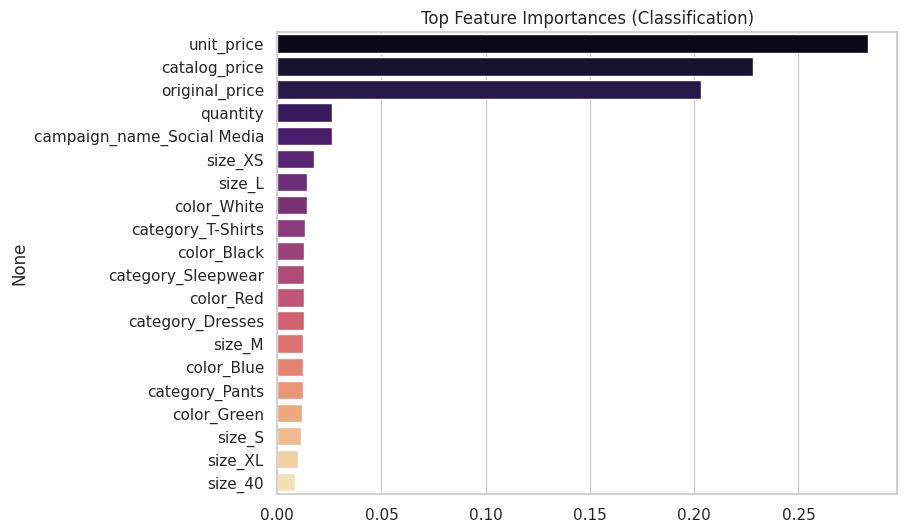

In [19]:
clf = clf_pipeline.named_steps['clf']
importances = clf.feature_importances_
# Safe guard lengths
feature_names = feature_names[:len(importances)]
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='magma')
plt.title("Top Feature Importances (Classification)")
plt.show()

In [20]:
# Save classifier
joblib.dump(clf_pipeline, "high_margin_classifier.joblib")
print("Saved classifier to high_margin_classifier.joblib")

Saved classifier to high_margin_classifier.joblib


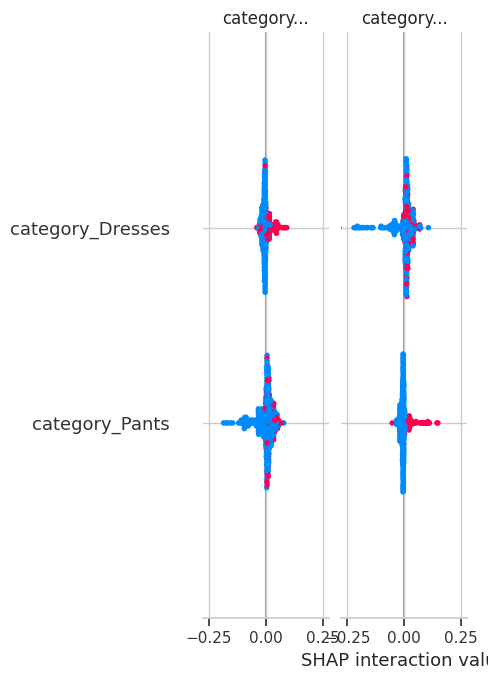

In [29]:

shap.initjs()

# Extract the fitted RandomForest model from the pipeline
clf = clf_pipeline.named_steps['clf']

# Transform test data using the fitted preprocessor
# Transform the test set with the pipeline's preprocessor
X_test_transformed = clf_pipeline.named_steps['preproc'].transform(X_test)

# Get feature names from the fitted OneHotEncoder + numeric columns
ohe = clf_pipeline.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
cat_names = ohe.get_feature_names_out(cat_features).tolist()
num_names = num_features
feature_names = cat_names + num_names

# Ensure correct explainer usage
explainer = shap.TreeExplainer(clf_pipeline.named_steps['clf'])
shap_values = explainer.shap_values(X_test_transformed)

# SHAP sometimes returns list for multiclass; in binary it can be [array, array]
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Take positive class impact

# Match shapes explicitly
assert X_test_transformed.shape[1] == len(feature_names), \
    f"Feature count mismatch: {X_test_transformed.shape[1]} vs {len(feature_names)}"

# Beeswarm plot (Global Feature Impact)
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="dot")
